In [174]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [175]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [176]:
len(words)

32033

In [177]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [219]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [220]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [321]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [180]:
C = torch.randn((27, 2))


In [181]:
C[5]

tensor([0.4292, 0.2281])

In [182]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.4292, 0.2281])

In [183]:
C[X].shape

torch.Size([32, 3, 2])

In [184]:
X[13,2]

tensor(1)

In [185]:
C[X][13,2]

tensor([ 1.8568, -0.4740])

In [186]:
C[1]

tensor([ 1.8568, -0.4740])

In [187]:
emb = C[X]
emb.shape
emb

tensor([[[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [-0.1605, -0.8230]],

        [[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [ 0.4292,  0.2281]],

        [[-0.1605, -0.8230],
         [ 0.4292,  0.2281],
         [ 0.1847, -0.4149]],

        [[ 0.4292,  0.2281],
         [ 0.1847, -0.4149],
         [ 0.1847, -0.4149]],

        [[ 0.1847, -0.4149],
         [ 0.1847, -0.4149],
         [ 1.8568, -0.4740]],

        [[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [-0.1605, -0.8230]],

        [[-0.1605, -0.8230],
         [-0.1605, -0.8230],
         [-0.2392,  0.8671]],

        [[-0.1605, -0.8230],
         [-0.2392,  0.8671],
         [ 1.9192,  0.5768]],

        [[-0.2392,  0.8671],
         [ 1.9192,  0.5768],
         [ 0.5699, -0.2114]],

        [[ 1.9192,  0.5768],
         [ 0.5699, -0.2114],
         [-0.6608, -1.0366]],

        [[ 0.5699, -0.2114],
         [-0.6608, -1.0366],
         [ 0.5699, -0.2114]],

        [[-0.6608, -1

In [188]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# emb @ W1 + b1

In [189]:
# F = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

In [190]:
unbinded = torch.unbind(emb, 1)

In [191]:
# Optimize tensor view manipulation

In [192]:
a = torch.arange(18)

In [193]:
# no memory is being changed/copied/created etc. when .view is being called
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [194]:
# always a 1-dimensional vector
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [195]:
emb.shape

torch.Size([32, 3, 2])

In [196]:
# more efficient and easier than bind/unbind
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [197]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
# pytorch can infer missing shape of matrix with -1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape # 100 activations for each of our 32 examples

torch.Size([32, 100])

In [198]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [199]:
logits = h @ W2 + b2

In [200]:
counts = logits.exp()

In [201]:
prob = counts / counts.sum(1, keepdims=True)

In [202]:
# index into the rows of prob, pluck out the probability assigned to the correct character, and calculate loss
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.5355)

In [203]:
# ---- clearer sequence -----

In [325]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [376]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2] # cluster parameters into single list

In [377]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [378]:
# emb = C[X] # (32, 3, 2)
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2
# # counts = logits.exp()
# # prob = counts / counts.sum(1, keepdims=True)
# # loss = -prob[torch.arange(32), Y].log().mean()
# # Above 3 commented lines can be done (more efficiently) with the following line
# F.cross_entropy(logits, Y) # how well neural network currently works with this set of parameters

In [379]:
for p in parameters:
    p.requires_grad = True

In [380]:
# step linearly between exponents of possible learning rates and space them exponentially
# creates possible learning rates to use
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [381]:
lri = []
lossi = []
stepi = []

In [382]:
for i in range(200000):
    # minibatch construct of 32 examples
    # better to have approximate gradient and take many more steps than exact gradient with fewer steps 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print (loss.item())

2.289271593093872


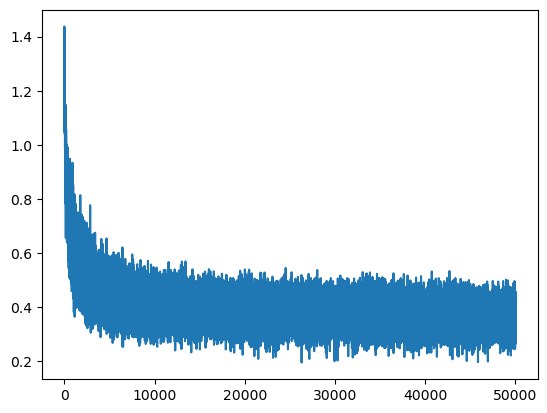

In [368]:
plt.plot(stepi, lossi)

In [383]:
emb = C[Xtr] # (32, 3, 2)
print(emb.shape)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

torch.Size([182625, 3, 10])


tensor(2.1327, grad_fn=<NllLossBackward0>)

In [384]:
emb = C[Xdev] # (32, 3, 2)
print(emb.shape)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

torch.Size([22655, 3, 10])


tensor(2.1734, grad_fn=<NllLossBackward0>)

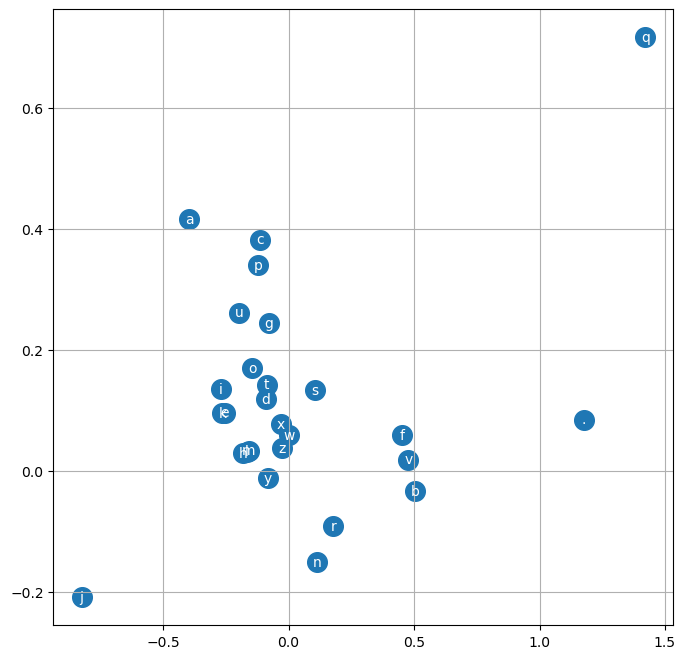

In [370]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# ~ 80%, 10%, 10%